
 Imports & Device Setup



In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Data Loading and Cleaning

In [2]:

def load_and_clean_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'(\w)(\.)', r'\1 .', text)
    text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    return words


Vocabulary Creation

In [3]:

def build_vocab(words):
    vocab = sorted(set(words))
    stoi = {'<PAD>': 0, '<UNK>': 1}
    for idx, w in enumerate(vocab, start=2):
        stoi[w] = idx
    itos = {i: w for w, i in stoi.items()}
    vocab_size = len(stoi)
    return stoi, itos, vocab_size


Dataset Creation

In [4]:
def create_dataset(words, stoi, itos, context_length, show_first_n=20):
    X, Y = [], []
    for i in range(len(words) - context_length):
        context = words[i:i+context_length]
        target = words[i+context_length]
        X.append([stoi.get(w, 1) for w in context])  # 1 = <UNK>
        Y.append(stoi.get(target, 1))

        if i < show_first_n:
            print(f"{' '.join(context)} ---> {target}")

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"\n Dataset created with shapes: X: {X.shape}, Y: {Y.shape}")
    return X, Y


MLP Next-Word Model

In [5]:

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, context_length, hidden1, hidden2=None,
                 activation='relu', dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)

        activation_layer = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU(),
            'leakyrelu': nn.LeakyReLU()
        }.get(activation.lower(), nn.ReLU())

        layers = [nn.Flatten(),
                  nn.Linear(context_length * emb_dim, hidden1),
                  activation_layer,
                  nn.Dropout(dropout)]
        if hidden2:
            layers += [nn.Linear(hidden1, hidden2),
                       activation_layer,
                       nn.Dropout(dropout)]
            layers += [nn.Linear(hidden2, vocab_size)]
        else:
            layers += [nn.Linear(hidden1, vocab_size)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.emb(x)
        return self.mlp(x)

    def get_embeddings(self):
        return self.emb.weight.detach().cpu().numpy()

Visualization Utility

In [6]:
def visualize_embeddings(model, itos, emb_dim=64, n_words=200, title="Embeddings"):
    embeddings = model.get_embeddings()
    if emb_dim != 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        emb_2d = tsne.fit_transform(embeddings[2:2+n_words])
    else:
        emb_2d = embeddings[2:2+n_words]
    plt.figure(figsize=(12, 10))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=12, alpha=0.7)
    for i in range(n_words):
        plt.annotate(itos[i+2], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.7)
    plt.title(title)
    plt.show()

Training Loop

In [7]:
def train_model(model, X, Y, epochs=1000, batch_size=4096, lr=0.003, print_every=100):
    optimizer = optim.AdamW(model.parameters(), lr=lr)  # Using AdamW optimizer
    loss_fn = nn.CrossEntropyLoss()                     # Using cross-entropy loss for classification

    losses = []  # To store average loss for each epoch

    for epoch in range(epochs):
        # Shuffle indices to randomize batches each epoch
        perm = torch.randperm(X.size(0))

        total_loss = 0  # Total loss for the epoch

        for i in range(0, X.size(0), batch_size):
            # Get batch indices
            idx = perm[i:i+batch_size]
            xb = X[idx].to(device)  # Batch input on device
            yb = Y[idx].to(device)  # Batch target on device

            optimizer.zero_grad()   # Reset gradients

            out = model(xb)         # Forward pass: get predictions

            loss = loss_fn(out, yb) # Compute cross-entropy loss

            loss.backward()         # Backward pass: compute gradients

            optimizer.step()        # Update model weights

            # Accumulate loss weighted by batch size for averaging later
            total_loss += loss.item() * xb.size(0)

        # Compute average loss for this epoch
        avg_loss = total_loss / X.size(0)
        losses.append(avg_loss)

        # Optionally print progress
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses  # Return list of epoch-wise average losses for plotting/analysis


Text Generation Utility

In [8]:
def generate_text(model, seed_text, length=30, context_length=5, temperature=1.0):
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)

    # Preprocess seed text: lowercase and split into words
    words_in = seed_text.lower().split()

    # Build initial context:
    # - If the seed text has fewer words than context_length, pad with 0 (<PAD>).
    # - Map words to indices using stoi; use 1 (<UNK>) if word is not found.
    context = (
        [0] * max(0, context_length - len(words_in)) +
        [stoi.get(w, 1) for w in words_in]
    )[-context_length:]

    generated = words_in.copy()  # Start generated sequence with the seed text

    for _ in range(length):
        # Prepare context tensor of shape [1, context_length]
        x = torch.tensor([context], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x).squeeze(0)      # Get raw scores for each vocab word
            logits = logits / temperature      # Adjust randomness

            probs = torch.softmax(logits, dim=-1).cpu()  # Convert to probabilities

        # Sample the next word index from the probability distribution
        next_idx = torch.multinomial(probs, num_samples=1).item()

        # Get the corresponding word (or <UNK> if missing)
        next_word = itos.get(next_idx, "<UNK>")

        # Append generated word to the sequence
        generated.append(next_word)

        # Update context for next prediction by removing the oldest and adding the new word
        context = context[1:] + [next_idx]

    # Return the generated words joined as a string
    return ' '.join(generated)

Saving Utilities

In [9]:
def save_artifacts(model, stoi, itos, emb_dim, context_length,
                   hidden1, hidden2, activation,
                   base_name="nextword_holmes_bundle"):
    """
    Saves:
    - model.state_dict
    - stoi and itos dictionaries
    - config dictionary (architecture hyperparameters)

    into a single .pt file for clean, consistent loading in Streamlit or CLI.
    """
    artifacts = {
        'model_state_dict': model.state_dict(),
        'stoi': stoi,
        'itos': itos,
        'config': {
            'vocab_size': len(stoi) + 1,  # +1 for padding/unknown handling
            'emb_dim': emb_dim,
            'context_length': context_length,
            'hidden1': hidden1,
            'hidden2': hidden2,
            'activation': activation
        }
    }

    save_path = f"{base_name}.pt"
    torch.save(artifacts, save_path)
    print(f"All artifacts saved to {save_path}")


# Tolstoy's War and Peace

In [10]:
# Download War and Peace dataset
!wget https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt -O tolstoys.txt

# Check file size
!ls -lh tolstoys.txt

# Display first 500 characters to inspect
with open('tolstoys.txt', 'r', encoding='utf-8') as f:
    print(f.read(500))


--2025-07-08 12:34:57--  https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3258246 (3.1M) [text/plain]
Saving to: ‘tolstoys.txt’

tolstoys.txt        100%[===================>]   3.11M  2.07MB/s    in 1.5s    

2025-07-08 12:34:59 (2.07 MB/s) - ‘tolstoys.txt’ saved [3258246/3258246]

-rw-r--r-- 1 root root 3.2M May 19  2015 tolstoys.txt
﻿"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and t

In [11]:
# Load and clean

words = load_and_clean_text('tolstoys.txt')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")

Sample cleaned words: ['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes', '.', 'but', 'i', 'warn', 'you', 'if']
Vocab size: 17522
Sample vocab mappings: [('<PAD>', 0), ('<UNK>', 1), ('.', 2), ('...', 3), ('....', 4), ('...ar', 5), ('...ate', 6), ('...ly', 7), ('...not', 8), ('...of', 9)]
well prince so genoa and ---> lucca
prince so genoa and lucca ---> are
so genoa and lucca are ---> now
genoa and lucca are now ---> just
and lucca are now just ---> family
lucca are now just family ---> estates
are now just family estates ---> of
now just family estates of ---> the
just family estates of the ---> buonapartes
family estates of the buonapartes ---> .
estates of the buonapartes . ---> but
of the buonapartes . but ---> i
the buonapartes . but i ---> warn
buonapartes . but i warn ---> you
. but i warn you ---> if
but i warn you if ---> you
i warn you if you ---> don
warn you if you don ---> t
you if you don t ---> tell
if 

In [12]:

# Hyperparameters
emb_dim = 128
hidden1 = 1024
hidden2 = 512
activation = 'gelu'
dropout = 0.2

# Instantiate
model = NextWordMLP(vocab_size, emb_dim, context_length, hidden1, hidden2, activation, dropout).to(device)

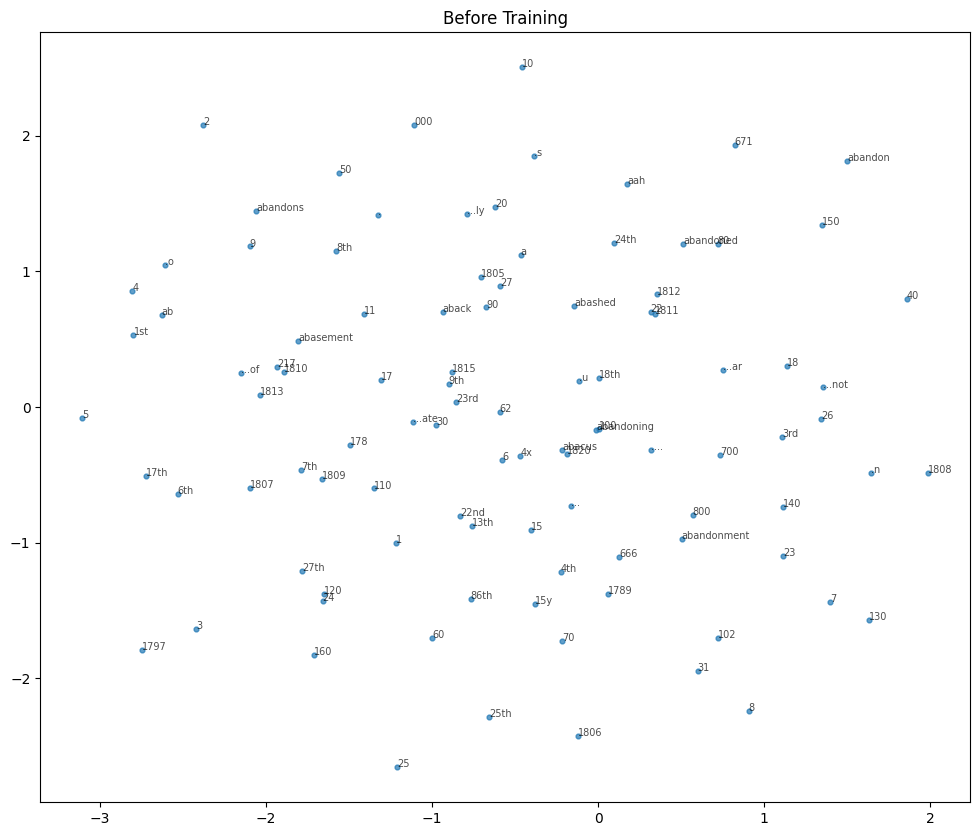

In [13]:

# Visualize Before
visualize_embeddings(model, itos, emb_dim, n_words=100, title="Before Training")


In [14]:
# Train
losses = train_model(model, X, Y, epochs=2000, batch_size=4096, lr=0.002)

Epoch 1/2000, Loss: 6.1759
Epoch 101/2000, Loss: 1.7709
Epoch 201/2000, Loss: 1.4678
Epoch 301/2000, Loss: 1.3242
Epoch 401/2000, Loss: 1.2436
Epoch 501/2000, Loss: 1.1897
Epoch 601/2000, Loss: 1.1557
Epoch 701/2000, Loss: 1.1224
Epoch 801/2000, Loss: 1.1031


KeyboardInterrupt: 

In [15]:
# Save
save_artifacts(
    model=model,
    stoi=stoi,
    itos=itos,
    emb_dim=emb_dim,
    context_length=context_length,
    hidden1=hidden1,
    hidden2=hidden2,
    activation=activation,
    base_name="tolstoys_128_gelu_mlp"
)

All artifacts saved to tolstoys_128_gelu_mlp.pt


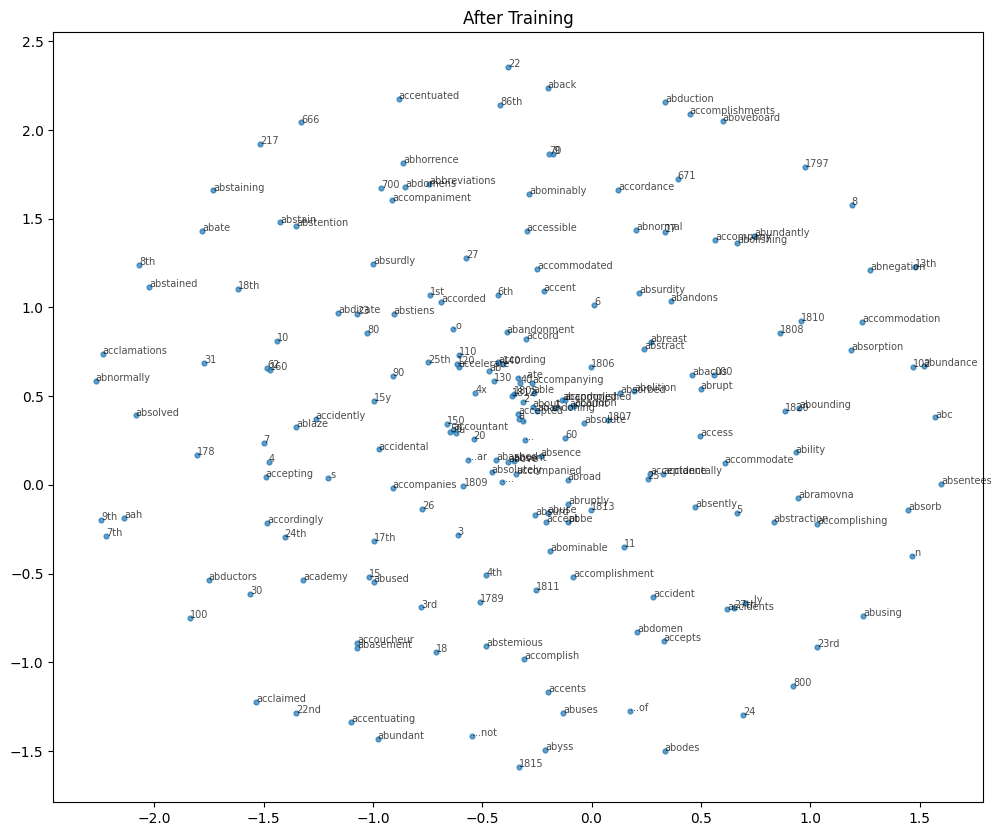

In [18]:
# Visualize After
visualize_embeddings(model, itos, emb_dim, n_words=200, title="After Training")


In [17]:
# Test Generation
seed = "We are accounted poor citizens"
generated = generate_text(model, seed, length=100, context_length=context_length)
print("\n Sample Generated Text:\n", generated)



 Sample Generated Text:
 we are accounted poor citizens of the was expression of his face . how am i to stifle in my heart these temptations of the devil . thrust them aside as she would questions continually recurred to her as to how she would order to be three in the morning . kutuzov wrote about the accounts . for this was it seems to me that christian love love of one s neighbor love of one s enemy for you said the old man meaning of life from the laws of reason the power of life means to us describe the news of our actions .
